# 데이터 기초 분석

공정 조건과 물성치 간의 대략적인 추세를 살펴보자.

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import scipy.stats as stats
from datetime import datetime

np.set_printoptions(precision=3)
pd.set_option('display.max_rows', None)

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [20, 16]

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio   
import plotly.express as px

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

#import env
os.getcwd()

/tmp/ipykernel_21607/1832095322.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


'/home/ysg/Projects/ai_data_2022-main'

## 데이터 읽기

- 특정 실험(장비, 소재, 적층 방향 동일)의 시편 데이터들 취합하여 비교하기
- 2022-07-11 현재 json 포맷으로 정리되지 않은 정보 존재


In [2]:
base_dir = os.path.join(f'/home', 'mygenie', 'data', 'AI_DB_CYAUTOTECH', '300장비')
data_dir_1 = os.path.join(base_dir, '6.sus_45_1circle_process', 'jsonsort')
data_dir_2 = os.path.join(base_dir, '7.sus_45_2circle_process', 'jsonsort')

In [3]:
!dir "$data_dir_1/laseroffset"

0  1  10  11  12  13  14  15  2  3  4  5  6  7	8  9


In [4]:
!dir "$data_dir_1/sub"

1.txt	11.txt	13.txt	15.txt	2.txt  4.txt  6.txt  8.txt
10.txt	12.txt	14.txt	16.txt	3.txt  5.txt  7.txt  9.txt


In [5]:
def read_data(data_dir):
    sample_id_list = [int(i) for i in os.listdir(os.path.join(data_dir, 'laseroffset'))]
    
    data = {}
    for sample_id in sample_id_list:
        # laser speed & power
        fname_laser_cond = os.path.join(data_dir, 'laseroffset', str(sample_id), 'laseroffset.txt')
        with open(fname_laser_cond) as f:
            lines = f.readlines()
        laser_cond = {k:v for k, v in [s.strip().split(':') for s in lines]}

        # mechanical properties
        with open(os.path.join(data_dir, 'sub', f'{sample_id+1}.txt'), encoding='utf-8-sig') as f:
            lines = f.readlines()
        prop = {k:v for k, v in [s.strip().split(':') for s in lines]}

        data[sample_id] = prop
        data[sample_id].update(laser_cond)
    return data

## 데이터 전처리

- 빈 칸 없애기, 단위 처리 등
- power 와 speed 가 정순으로 기록


In [6]:
import re
re_num = re.compile(r'([0-9\.]+)(.*)')

In [7]:
def preprocess(data): 
    # materials = ['SUS']
    # facilities = ['Vulcan 300']
    data_list = []
    for i in range(16):
        _data = data[i]

        __data = {}
        for k, v in _data.items():
            if k == 'power':
                __data['laser_power'] = float(v)     ## power 와 speed 
            elif k == 'speed':
                __data['laser_speed'] = float(v)     ## power 와 speed 
            else:
                val, unit = re_num.match(v).groups()
                k = k if len(unit) == 0 else f'{k}({unit})'
                __data[k] = float(val)

        data_list.append(__data)
    df = pd.DataFrame(data_list)
    df['laser_density'] = df['laser_power'] / df['laser_speed']
    return df

In [8]:
list_file = [data_dir_1, data_dir_2]
list_data = list()
list_df = list()
for _file in list_file:
    _data = read_data(_file)
    _df = preprocess(_data)
    list_data.append(_data)
    list_df.append(_df)

# 데이터 분석

In [9]:
# import matplotlib.pyplot as plt
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
# plt.rcParams['font.family'] = 'Malgun Gothic'

def plot_annot(df_plot, x_col, y_cols, figsize=(24, 5), ax=list(), marker='o', color='tab:blue', alpha=0.7, offset=0.0):
    
    if len(ax) <= 0: 
        fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    for i, c in enumerate(y_cols):
        x = df_plot[x_col]
        y = df_plot[c]
        ax[i].scatter(x, y, marker=marker, c=color, alpha=alpha)
        ax[i].set_title(c)
        ax[i].set_xlabel(x_col)

        xscale = (x.max()-x.min()) 
        yscale = (y.max()-y.min())
        xoffset = offset * xscale
        yoffset = offset * yscale
        for (_idx, _x, _y) in zip(x.index, x, y):
            ax[i].annotate(_idx, (_x+xoffset, _y+yoffset), c=color)
            

def plot_annot_comp(df_0, df_1, x_col, y_cols, figsize=(24, 5)):
    fig, ax = plt.subplots(1, len(y_cols), figsize=figsize)
    plot_annot(df_0, x_col, y_cols, figsize=figsize, ax=ax, marker='o', color='tab:blue', alpha=0.7, offset=-0.04)
    plot_annot(df_1, x_col, y_cols, figsize=figsize, ax=ax, marker='^', color='tab:red', alpha=0.7, offset=0.01)
    
#     for i, c in enumerate(y_cols):
#         x_0 = df_0[x_col]
#         y_0 = df_0[c]
#         ax[i].scatter(x_0, y_0)
#         ax[i].set_title(c)
#         ax[i].set_xlabel(x_col)

#         for (_idx, _x, _y) in zip(x_0.index, x_0, y_0):
#             ax[i].annotate(_idx, (_x, _y))

## 전체 데이터 분석

In [10]:
_idx = [True] * 16

# _idx[0] = False
# _idx[6] = False
# _idx[7] = False

# _idx[12] = False

df_0 = list_df[0]
df_1 = list_df[1]

In [11]:
df_0['trial'] = [ '1' for i in range(df_0.shape[0]) ]
df_0

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,513.18,566.81,13.5,7.81,264.0,1300.0,0.203077,1
1,502.20,593.89,38.5,7.82,360.0,1300.0,0.276923,1
2,520.10,620.79,36.5,7.82,312.0,1300.0,0.240000,1
3,523.68,614.51,38.5,7.80,408.0,1300.0,0.313846,1
4,433.80,434.08,7.7,7.82,264.0,1100.0,0.240000,1
5,537.82,630.19,36.5,7.87,360.0,1100.0,0.327273,1
6,523.32,625.81,36.5,7.82,312.0,1100.0,0.283636,1
7,529.46,627.32,38.5,7.78,408.0,1100.0,0.370909,1
8,552.56,645.28,34.6,7.80,264.0,900.0,0.293333,1
9,525.29,623.65,38.5,7.86,360.0,900.0,0.400000,1


In [12]:
df_1['trial'] = [ '2' for i in range(df_0.shape[0]) ]
df_1

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,524.73,529.91,5.8,7.81,264.0,1300.0,0.203077,2
1,499.44,514.07,3.8,7.82,360.0,1300.0,0.276923,2
2,531.52,624.02,30.8,7.82,312.0,1300.0,0.240000,2
3,550.15,636.87,23.1,7.80,408.0,1300.0,0.313846,2
4,539.46,628.42,30.8,7.82,264.0,1100.0,0.240000,2
5,548.77,644.49,40.4,7.87,360.0,1100.0,0.327273,2
6,548.38,641.99,42.3,7.82,312.0,1100.0,0.283636,2
7,557.55,652.86,42.3,7.78,408.0,1100.0,0.370909,2
8,551.02,646.73,42.3,7.80,264.0,900.0,0.293333,2
9,547.68,660.33,44.2,7.86,360.0,900.0,0.400000,2


In [13]:
df_join = pd.concat([df_0, df_1], ignore_index=True)
df_join

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density,trial
0,513.18,566.81,13.5,7.81,264.0,1300.0,0.203077,1
1,502.20,593.89,38.5,7.82,360.0,1300.0,0.276923,1
2,520.10,620.79,36.5,7.82,312.0,1300.0,0.240000,1
3,523.68,614.51,38.5,7.80,408.0,1300.0,0.313846,1
4,433.80,434.08,7.7,7.82,264.0,1100.0,0.240000,1
5,537.82,630.19,36.5,7.87,360.0,1100.0,0.327273,1
6,523.32,625.81,36.5,7.82,312.0,1100.0,0.283636,1
7,529.46,627.32,38.5,7.78,408.0,1100.0,0.370909,1
8,552.56,645.28,34.6,7.80,264.0,900.0,0.293333,1
9,525.29,623.65,38.5,7.86,360.0,900.0,0.400000,1


[Text(0, 0, '0.2031'),
 Text(1, 0, '0.24'),
 Text(2, 0, '0.2769'),
 Text(3, 0, '0.2836'),
 Text(4, 0, '0.2933'),
 Text(5, 0, '0.3138'),
 Text(6, 0, '0.3273'),
 Text(7, 0, '0.3467'),
 Text(8, 0, '0.3709'),
 Text(9, 0, '0.3771'),
 Text(10, 0, '0.4'),
 Text(11, 0, '0.4457'),
 Text(12, 0, '0.4533'),
 Text(13, 0, '0.5143'),
 Text(14, 0, '0.5829')]

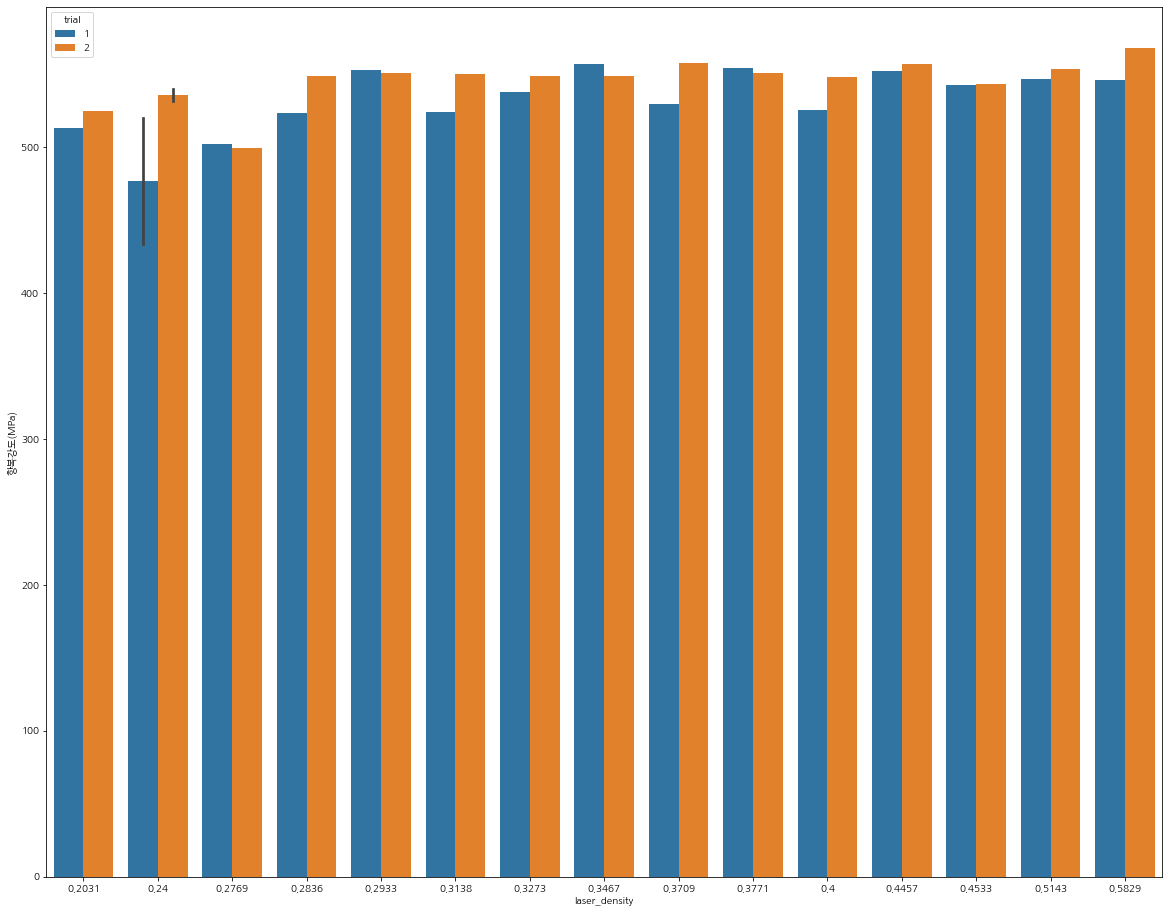

In [14]:
ax = sns.barplot(x='laser_density', y='항복강도(MPa)', hue='trial', data=df_join)
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 4)) for label in labels])

In [15]:
df_0.describe()

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,528.701250,611.985625,32.512500,7.817500,336.000000,1000.000000,0.354312
std,30.036127,55.238543,12.851504,0.036968,55.425626,230.940108,0.104882
min,433.800000,434.080000,0.800000,7.750000,264.000000,700.000000,0.203077
25%,522.515000,609.355000,36.025000,7.797500,300.000000,850.000000,0.281958
50%,533.640000,626.565000,38.500000,7.820000,336.000000,1000.000000,0.336970
75%,547.905000,645.297500,38.500000,7.830000,372.000000,1150.000000,0.411429
max,557.160000,656.820000,42.300000,7.900000,408.000000,1300.000000,0.582857


In [16]:
df_1.describe()

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,544.975625,629.177500,33.050000,7.817500,336.000000,1000.000000,0.354312
std,15.761166,45.086166,14.528088,0.036968,55.425626,230.940108,0.104882
min,499.440000,514.070000,3.800000,7.750000,264.000000,700.000000,0.203077
25%,542.437500,627.320000,28.875000,7.797500,300.000000,850.000000,0.281958
50%,548.715000,645.300000,41.350000,7.820000,336.000000,1000.000000,0.336970
75%,551.700000,655.332500,42.300000,7.830000,372.000000,1150.000000,0.411429
max,567.500000,672.620000,44.200000,7.900000,408.000000,1300.000000,0.582857


<AxesSubplot:>

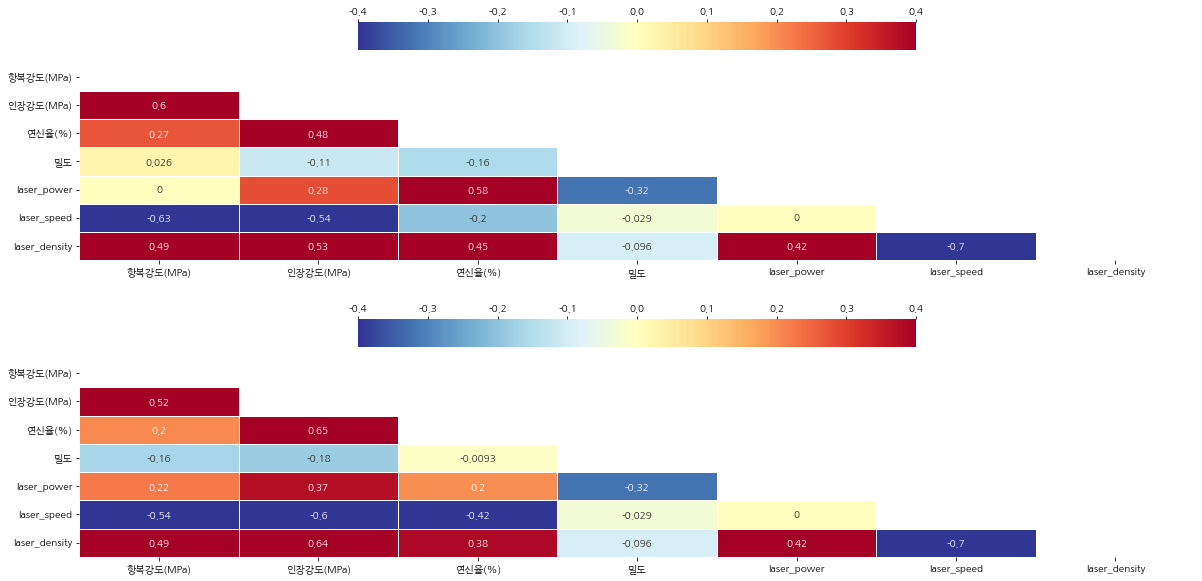

In [17]:
corr_0 = df_0.loc[_idx, :].corr(method='kendall') #.abs() #method={‘pearson’, ‘kendall’, ‘spearman’}
corr_1 = df_1.loc[_idx, :].corr(method='kendall')

# mask_0 = None ; mask_1 = None
mask_0 = np.zeros_like(corr_0, dtype=np.bool_)
mask_0[np.triu_indices_from(mask_0)] = True
mask_1 = np.zeros_like(corr_1, dtype=np.bool_)
mask_1[np.triu_indices_from(mask_1)] = True

fig, axes = plt.subplots(2,1, figsize=(20, 10))
axes = axes.flatten()
sns.heatmap(corr_0, cmap = 'RdYlBu_r', ax=axes[0], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_0, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})
sns.heatmap(corr_1, cmap = 'RdYlBu_r', ax=axes[1], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_1, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})

### 공정변수 vs 기계적 특성치 분포

In [18]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)','밀도']

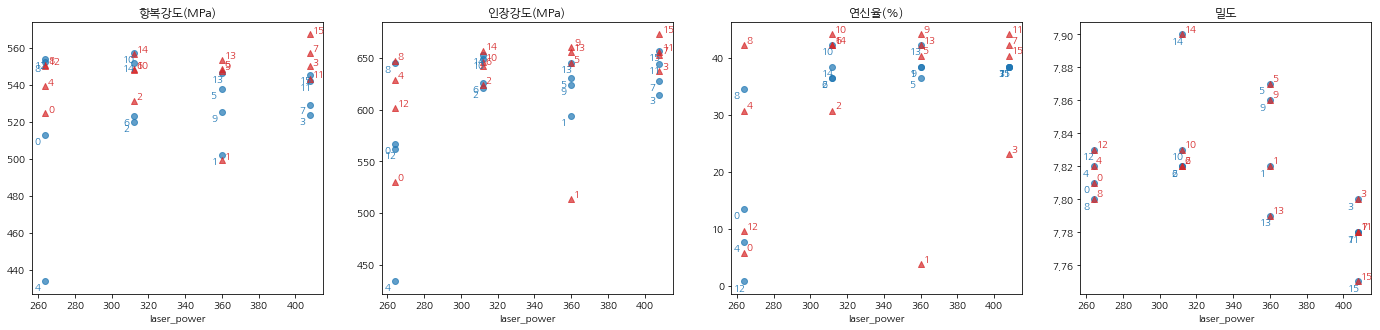

In [19]:
plot_annot_comp(df_0, df_1, 'laser_power', y_cols)

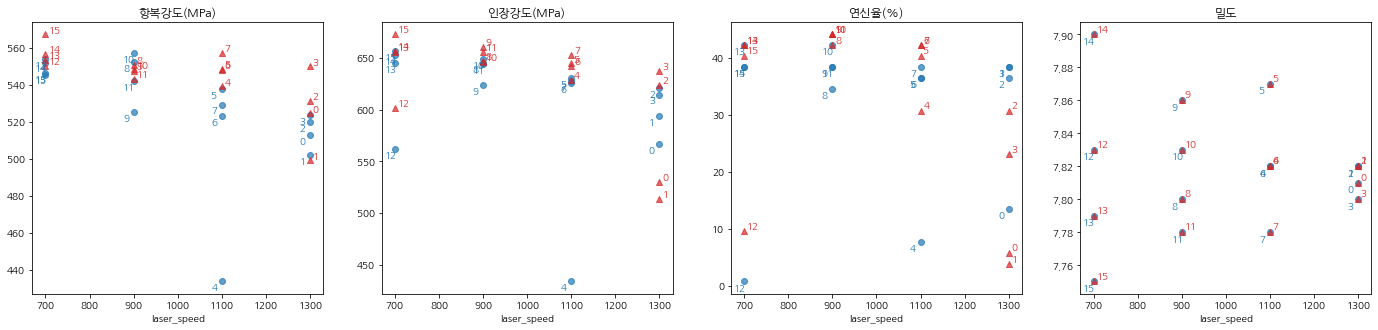

In [20]:
plot_annot_comp(df_0, df_1, 'laser_speed', y_cols)

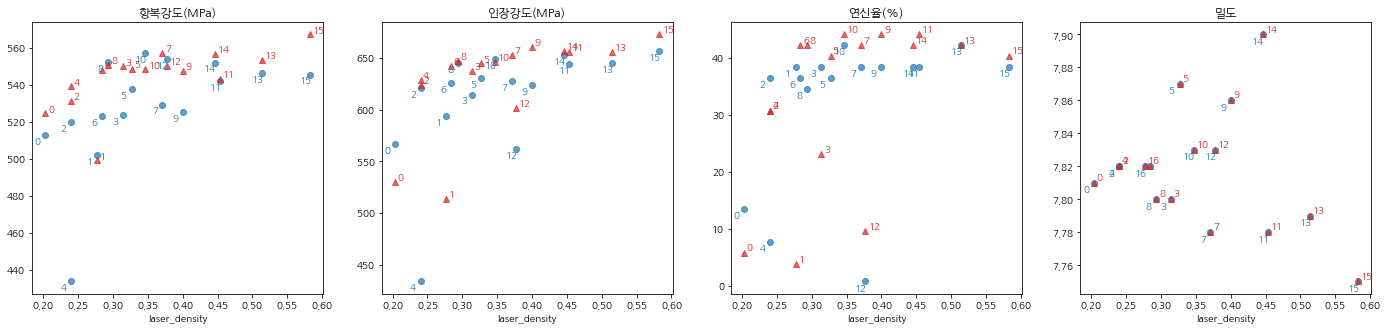

In [21]:
plot_annot_comp(df_0, df_1, 'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

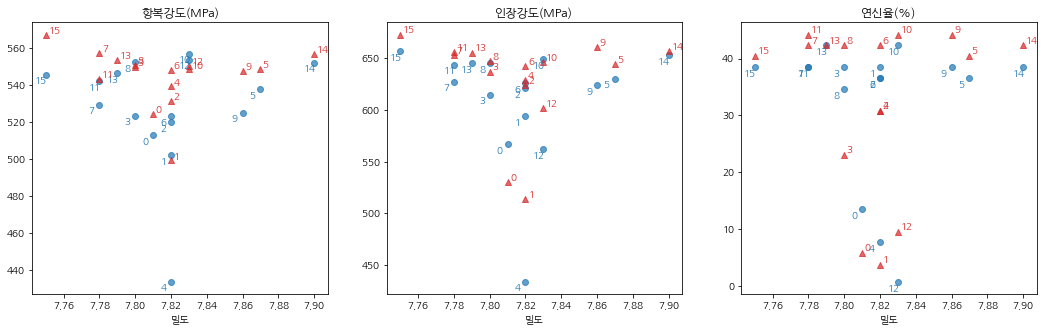

In [22]:
y_cols = ['항복강도(MPa)','인장강도(MPa)','연신율(%)',]
plot_annot_comp(df_0, df_1, '밀도', y_cols, figsize=(18, 5))

## 이상치 제외 데이터 분석 (#1: 1, 12 번 제외)

In [23]:
_idx_0 = [True] * 16

_idx_0[1] = False
_idx_0[12] = False

df_corr_0 = df_0.loc[_idx_0, :].corr()
df_corr_0

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.971686,0.828347,-0.001852,0.351465,-0.477675,0.521871
인장강도(MPa),0.971686,1.000000,0.903306,-0.034973,0.467363,-0.432340,0.550990
연신율(%),0.828347,0.903306,1.000000,-0.010448,0.608735,-0.433170,0.591475
밀도,-0.001852,-0.034973,-0.010448,1.000000,-0.372071,-0.008909,-0.246406
laser_power,0.351465,0.467363,0.608735,-0.372071,1.000000,-0.182526,0.651068
laser_speed,-0.477675,-0.432340,-0.433170,-0.008909,-0.182526,1.000000,-0.839329
laser_density,0.521871,0.550990,0.591475,-0.246406,0.651068,-0.839329,1.000000


## 이상치 제외 데이터 분석 (#2: 0, 4, 12 번 제외)

In [24]:
_idx_1 = [True] * 16

_idx_1[0] = False
_idx_1[4] = False
_idx_1[12] = False

df_corr_1 = df_1.loc[_idx_1, :].corr()
df_corr_1

,항복강도(MPa),인장강도(MPa),연신율(%),밀도,laser_power,laser_speed,laser_density
항복강도(MPa),1.000000,0.942693,0.811132,-0.141393,0.123871,-0.634244,0.578547
인장강도(MPa),0.942693,1.000000,0.908062,-0.080987,0.072460,-0.618439,0.526559
연신율(%),0.811132,0.908062,1.000000,0.040408,-0.143539,-0.676529,0.433422
밀도,-0.141393,-0.080987,0.040408,1.000000,-0.464465,0.015226,-0.297835
laser_power,0.123871,0.072460,-0.143539,-0.464465,1.000000,0.069171,0.468568
laser_speed,-0.634244,-0.618439,-0.676529,0.015226,0.069171,1.000000,-0.827599
laser_density,0.578547,0.526559,0.433422,-0.297835,0.468568,-0.827599,1.000000


<AxesSubplot:>

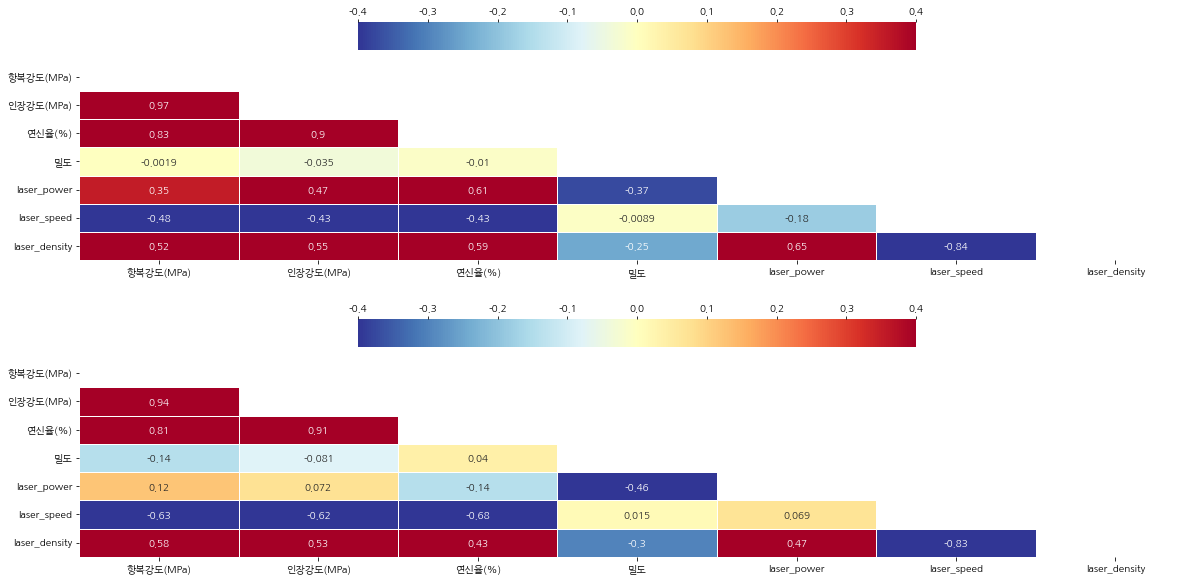

In [25]:
# mask_0 = None ; mask_1 = None
mask_0 = np.zeros_like(df_corr_0, dtype=np.bool_)
mask_0[np.triu_indices_from(mask_0)] = True
mask_1 = np.zeros_like(df_corr_1, dtype=np.bool_)
mask_1[np.triu_indices_from(mask_1)] = True

fig, axes = plt.subplots(2,1, figsize=(20, 10))
axes = axes.flatten()
sns.heatmap(df_corr_0, cmap = 'RdYlBu_r', ax=axes[0], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_0, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})
sns.heatmap(df_corr_1, cmap = 'RdYlBu_r', ax=axes[1], annot=True, vmin = -0.4, vmax = 0.4, mask=mask_1, linewidth=.5, cbar_kws={"location": 'top', "shrink": .5})

### 공정변수 vs 기계적 특성치 분포

In [26]:
y_cols = df_0.columns[:4].tolist()
df_0_t = df_0.loc[_idx_0, :]
df_1_t = df_1.loc[_idx_1, :]


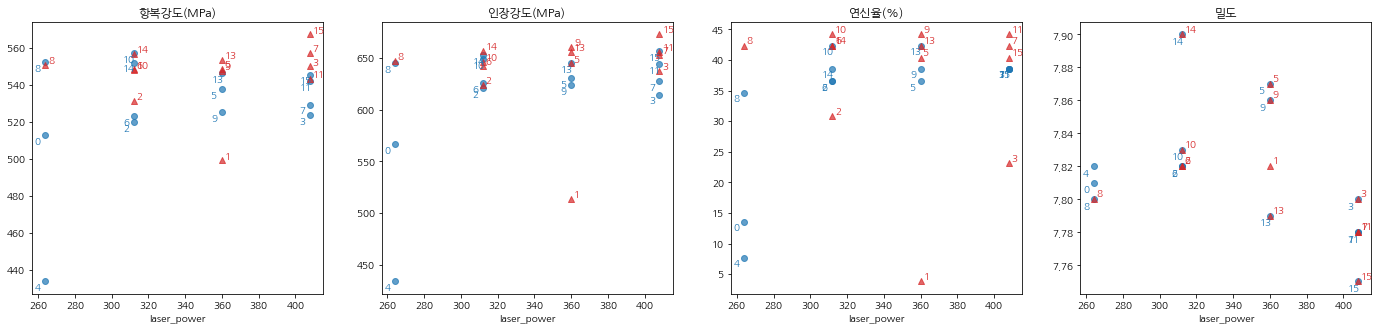

In [27]:
plot_annot_comp(df_0_t, df_1_t, 'laser_power', y_cols)

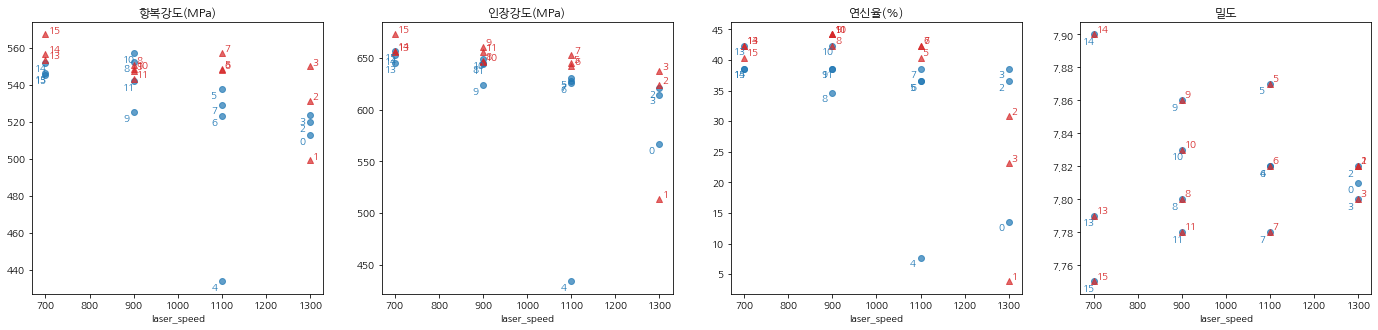

In [28]:
plot_annot_comp(df_0_t, df_1_t,  'laser_speed', y_cols)

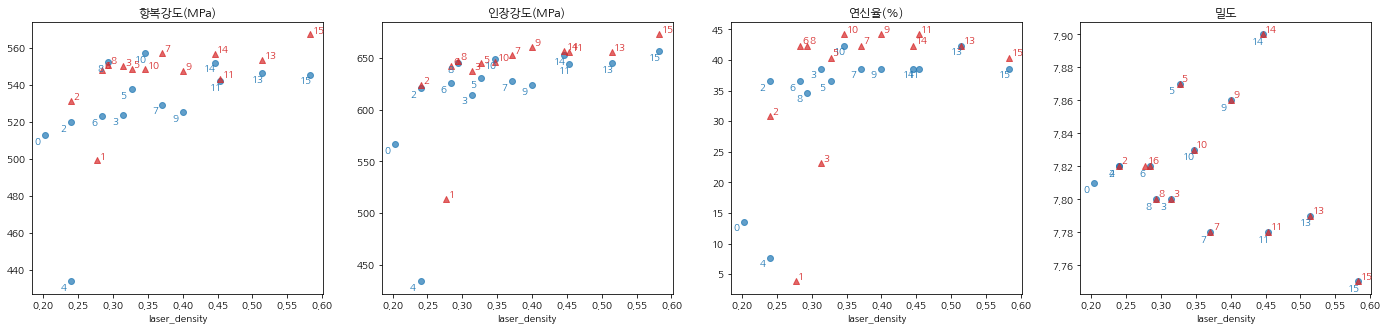

In [29]:
plot_annot_comp(df_0_t, df_1_t,  'laser_density', y_cols)

### 밀도 vs 타 특성치 분포

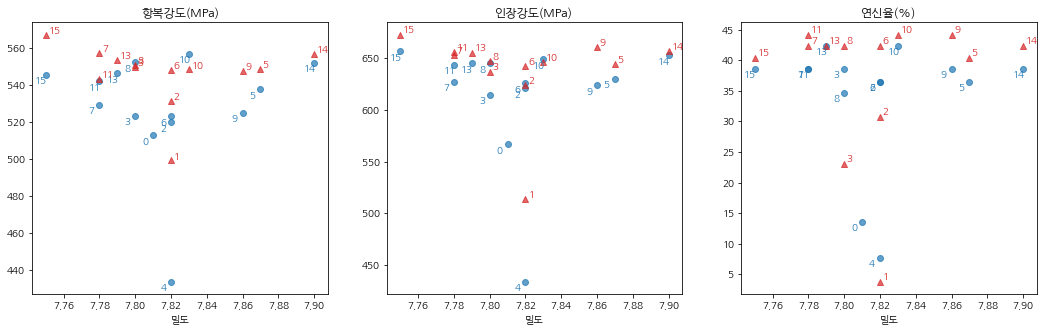

In [30]:
y_cols = df_0.columns[:3].tolist()

plot_annot_comp(df_0_t, df_1_t,  '밀도', y_cols, figsize=(18, 5))